### GAMALOS (GAlaxies MAking LOve Simulation)

Report: write a short report containing:
- a short introduction to the N-body problem, the difference between
collisional and collisionless systems and the force estimate in
collisionless simulations based on tree algorithms. Short general
description of the fireworks package and its implementation.
- Description of the methods (integrators, force estimator) used.
- Description of the initial conditions and simulation setup.
- Results and discussion. They depends on the specific project you
chose, but I expect at least one plot showing the main conclusion of
your analysis.

<div class='alert alert-danger' role='alert'>
Inserisci info teoriche
</div>

### Computation

In [1]:
#first of all, we import all the packages for Particles, integrators, ic...

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from fireworks.nbodylib.integrators import integrator_leapfrog, integrator_leapfrog_galaxy, integrator_rungekutta, integrator_tsunami
from fireworks.nbodylib.dynamics import acceleration_pyfalcon, acceleration_jerk_direct
from fireworks.nbodylib.timesteps import adaptive_timestep_r
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
import time

#from mpl_toolkits.mplot3d import Axes3D

#%matplotlib widget

We can import the data of one galaxy at first. The units are still Nbody units.

In [2]:
df_0 = pd.read_csv("data_cvs/Nbody_disc.csv")

# Slicing the dataframe to reduce computation time
num_particles = 5*1e2
df = df_0.iloc[:int(num_particles)]

df.head(10)

,mass,x,y,z,vx,vy,vz
0,1.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,1.000000e-11,-3.419583,-1.901788,0.0,0.118878,-0.213752,0.0
2,1.000000e-11,-14.046839,-2.403541,0.0,0.040952,-0.239330,0.0
3,1.000000e-11,-4.618003,6.269821,0.0,-0.222721,-0.164044,0.0
4,1.000000e-11,-6.045516,0.257974,0.0,-0.011730,-0.274897,0.0
5,1.000000e-11,-1.393104,1.578234,0.0,-0.124900,-0.110249,0.0
6,1.000000e-11,-1.150877,-1.762433,0.0,0.139480,-0.091081,0.0
7,1.000000e-11,0.593887,-1.003781,0.0,0.086283,0.051049,0.0
8,1.000000e-11,2.423492,-10.266498,0.0,0.257402,0.060762,0.0
9,1.000000e-11,-3.279328,5.118040,0.0,-0.231783,-0.148512,0.0


In [3]:
#I create a class with the mass, pos, vel of each element of the Galaxy

masses = df[['mass']]
positions = df[['x', 'y', 'z']]
velocities = df[['vx', 'vy', 'vz']]

# reshape mass array to 1D array (required by pyfalcon)
masses = masses.values.reshape(-1)
print(masses.shape)

Galaxy1 = Particles(positions.values, velocities.values, masses)

(500,)


In [4]:
#I can do the same for the other Galaxy. This second galaxy is the same as the first one, but translated by a certain value. In particular I have
pos_translation = np.array((40., 20., 0.))
vel_translation = np.array((-0.2, 0., 0.))

#So, I just apply this translation to find the second galaxy
positions_gal_2 = positions.values + pos_translation
velocities_gal_2 = velocities.values + vel_translation
Galaxy2 = Particles(positions_gal_2, velocities_gal_2, masses)

plot the first galaxy

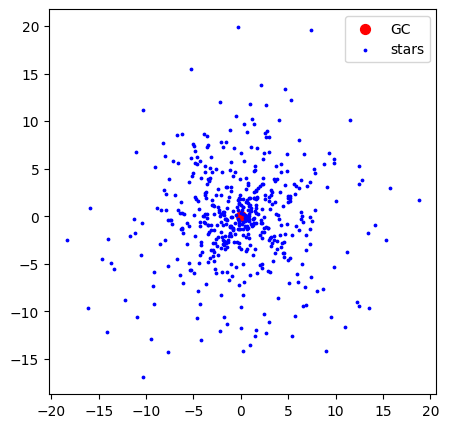

In [5]:
plt.figure(figsize=(5,5))
plt.scatter(Galaxy1.pos[0,0], Galaxy1.pos[0,0], label='GC', s=50, color='red')
plt.scatter(Galaxy1.pos[1:,0], Galaxy1.pos[1:,1], label='stars', s=3, color='blue')
plt.legend()
plt.show()

### Now let's try to run a test orbit simulation with pyfalcon:

Let's try an orbital simulation of the first galaxy to see if the integration works (in this test we used the leap-frog method)

In [6]:
def rotation_curve(galaxy: Particles):

    pos_rescaled = galaxy.pos[1:, :] - galaxy.pos[0,:]
    vel_rescaled = galaxy.vel[1:, :] - galaxy.vel[0,:]

    r_cyl   = np.sqrt(np.sum(pos_rescaled[:,:2]**2., axis=1))
    phi     = np.arctan2(pos_rescaled[:,1], pos_rescaled[:,0])
    z       = pos_rescaled[:,2]

    v_phi   = vel_rescaled[:,1] * np.cos(phi) - vel_rescaled[:,0] * np.sin(phi)

    return r_cyl, v_phi, z 


def integration_leapfrog(galaxy: Particles, h: float, tsimulation: float, t: float, soft: float):

    N = len(galaxy.mass)         # number of particles in the galaxy
    path = [galaxy.pos]
    velocity = [galaxy.vel]
    time   = [t]
    
    Etot_0, Ekin_0, Epot_0 = galaxy.Etot_vett()
    Etot = [Etot_0]
    Ekin = [Ekin_0]
    Epot = [Epot_0]

    r_cyl, vel_phi, z = rotation_curve(galaxy)

    R_cyl = [r_cyl]
    V_phi = [vel_phi]
    Z = [z]

    while (t <= tsimulation):
        result = integrator_leapfrog_galaxy(particles=galaxy, tstep=h, acceleration_estimator=acceleration_pyfalcon, softening=soft)
        galaxy, updated_acc, _, _ = result
        #galaxy.pos -= galaxy.pos[0]  # move the galaxy to the center of mass
        #galaxy.vel -= galaxy.vel[0]  # move the galaxy to the center of mass
        path.append(galaxy.pos)
        velocity.append(galaxy.vel)
            
        Etot_n, Ekin_n, Epot_n = galaxy.Etot_vett()
        Etot.append(Etot_n)
        Ekin.append(Ekin_n)
        Epot.append(Epot_n)
        
        t += h
        time.append(t)

        R, V, z = rotation_curve(galaxy)
        R_cyl.append(R)
        V_phi.append(V)
        Z.append(z)


    path = np.array(path)
    velocity = np.array(velocity)
    time   = np.array(time)

    Etot_leapfrog = np.array(Etot)
    Ekin_leapfrog = np.array(Ekin)
    Etot_leapfrog = np.array(Epot)

    R_cyl = np.array(R_cyl)
    V_phi = np.array(V_phi)
    Z = np.array(Z)

    return path, velocity, Etot, Ekin, Epot, time, R_cyl, V_phi, Z

In [7]:
# First we calculate the period of the galaxy (approximatly, I'm not sure if is the right method)
# with the formula T = 2*pi*sqrt(a^3/GM).
# We're in n-body units so G=1 and for the radius I take the maximum distance from the centre of the galaxiy (a = r_max)
# and we suppose a cicurlar orbits so e=0

plummer_scale_lenght = 5.              # scale lenght of the plummer sphere
e = 0.                                  # eccentricity
radius = np.average(Galaxy1.radius())       # radius of the galaxy
print(f'radius of the galaxy: {radius}')

a = radius / (1 - e)                    # semi-major axis
M = Galaxy1.mass[0]                     # taking the mass of center of mass

T = 2*np.pi*np.sqrt(a**3/M)             # period of the galaxy

print(f'Period of the galaxy (approximately): {T}')

# Now we can define the time of simulation and the number of steps
t0 = 0.                         # initial time
tsimulation = 1*T              # time of simulation
N = int(2*1e3)                    # number of steps
h = (tsimulation - t0)/N        # time steps
                                                                                          

radius of the galaxy: 5.957848151363805
Period of the galaxy (approximately): 91.3721856496133


In [8]:
Galaxy1_test = Galaxy1.copy()

Galaxy1_orbit, Galaxy1_stars_vel, Galaxy1_Etot, Galaxy1_Ekin, Galaxy1_Epot, Galaxy1_time, Galaxy1_Rcyl, Galaxy1_Vphi, Galaxy1_z = integration_leapfrog(galaxy=Galaxy1_test, h=h, 
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

/root/miniconda3/lib/python3.10/site-packages/fireworks-0.0.5-py3.10.egg/fireworks/particles.py:275: RuntimeWarning: divide by zero encountered in divide


Now let's try to print the particles evolution within a Period time

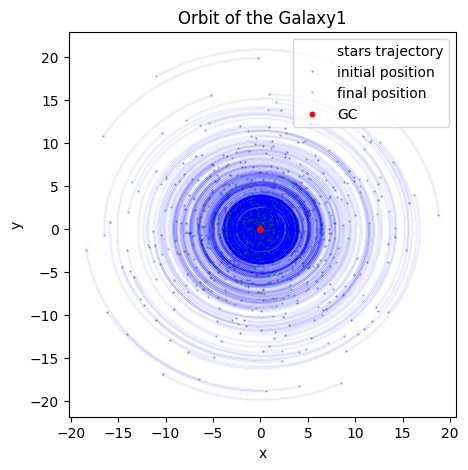

In [9]:
#let us make a plot
plt.figure(figsize=(5,5))
plt.scatter(Galaxy1_orbit[:,1:,0], Galaxy1_orbit[:,1:,1], s=0.05, color='b', label='stars trajectory', alpha=0.01)
plt.plot(Galaxy1_orbit[0,1:,0], Galaxy1_orbit[0,1:,1], 'o', markersize=0.5, c='b', label='initial position', alpha=0.5)
plt.plot(Galaxy1_orbit[-1,1:,0], Galaxy1_orbit[-1,1:,1], 'o', markersize=0.5, c='g', label='final position', alpha=0.5)
plt.scatter(Galaxy1_orbit[:,0,0], Galaxy1_orbit[:,0,1], s=10, color='r', label='GC', zorder=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit of the Galaxy1')
plt.legend(loc='upper right')
plt.show()

Let's see the Total Energy Error of our simulation. First we define the *general function*

In [10]:
def total_energy_error(Etot):
    energy_error = np.zeros_like(Etot)

    for i in range(len(Etot)):
        energy_error[i] = np.abs((Etot[i] - Etot[0])/Etot[0])

    return energy_error

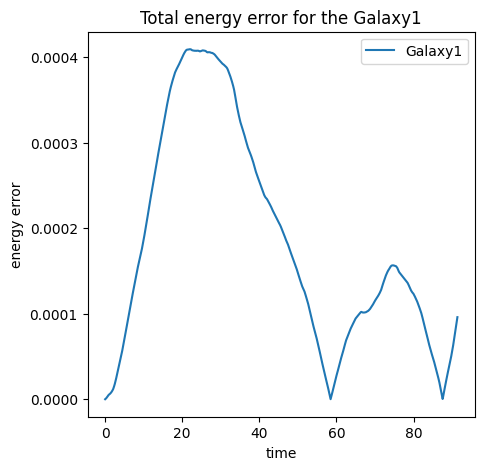

In [11]:
# I calculate the error of the total energy for the Galaxy1
energy_error = total_energy_error(Etot=Galaxy1_Etot)

# Now I can plot the error of the total energy for the Galaxy1
plt.figure(figsize=(5,5))
plt.plot(Galaxy1_time, energy_error, label='Galaxy1')
plt.xlabel('time')
plt.ylabel('energy error')
plt.title('Total energy error for the Galaxy1')
plt.legend()
plt.show()

### Rotation Curve:
Let's check if the velocity curve still the same also after one revolution around the Galatic Center


(500,)


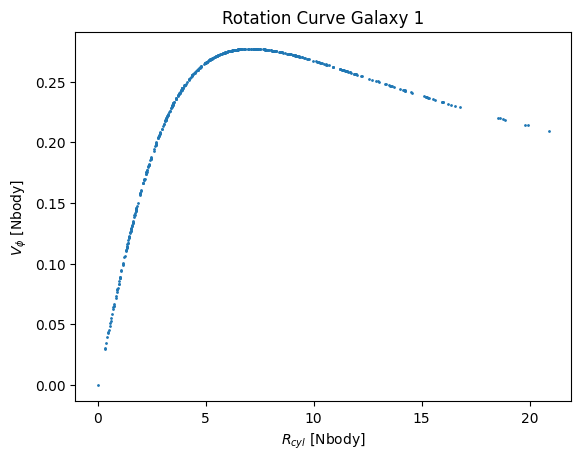

In [12]:
# convert to cylindrical coordinates

Rcyl = np.sqrt(Galaxy1.pos[:, 0] ** 2 + Galaxy1.pos[:, 1] ** 2)
print(Rcyl.shape)
phi = np.arctan2(Galaxy1.pos[:, 1], Galaxy1.pos[:, 0])
z = Galaxy1.pos[:, 2]

vel_phi = Galaxy1.vel[:, 1] * np.cos(phi) - Galaxy1.vel[:, 0] * np.sin(phi)

plt.figure()
plt.plot(Rcyl, vel_phi, 'o', markersize=1)
plt.xlabel("$R_{cyl}$ [Nbody]")
plt.ylabel("$V_{\phi}$ [Nbody]")
plt.title("Rotation Curve Galaxy 1")
plt.show()

let's see if the $V_{\phi}$ remains the same for all the timescale

In [13]:
print(Galaxy1_Rcyl.shape)
print(Galaxy1_Vphi.shape)
print(Galaxy1_time.shape)

(2001, 499)
(2001, 499)
(2001,)


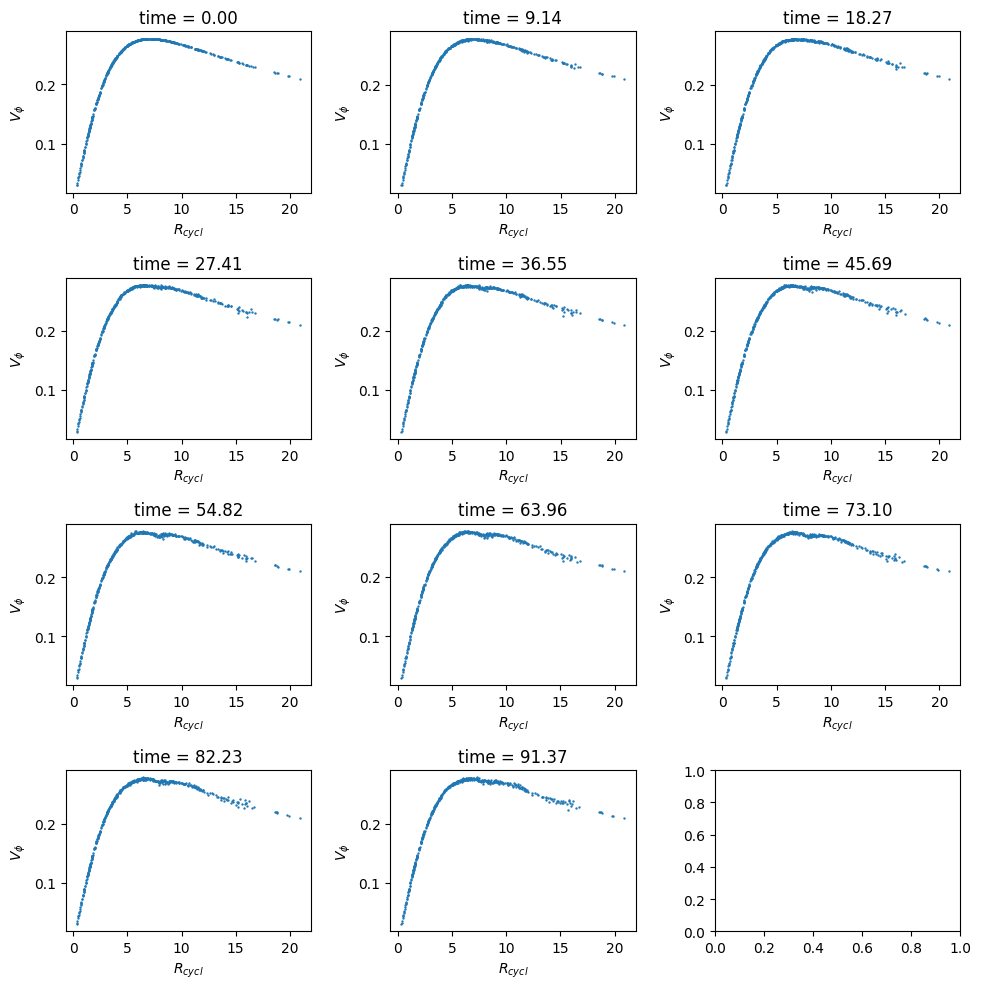

In [14]:
fig, axs = plt.subplots(4, 3, figsize=(10,10))

i_plot = 0
for i in range(0, len(Galaxy1_time), int(len(Galaxy1_time)/10)):
    ax = axs.flatten()[i_plot]
    time_prov = (i*h)/tsimulation
    ax.scatter(Galaxy1_Rcyl[i,:], Galaxy1_Vphi[i,:], s=0.5)

    ax.set_xlabel('$R_{cycl}$')
    ax.set_ylabel('$V_{\phi}$')
    ax.set_title(f'time = {Galaxy1_time[i]:.2f}')
    
    i_plot += 1

plt.tight_layout()
plt.show()

In [15]:
'''
# convert to cylindrical coordinates for all the timmeframe

Rcyl = np.linalg.norm(Galaxy1_orbit[:, :, :], axis=2)    # radial coordinate for each timeframe and particle
print('Radial coordinate of the first 10 particles at the first timescale: \n',Rcyl[0,1:11])

phi = np.zeros_like(Rcyl)                                   
for i in range(Rcyl.shape[0]):
    phi[i,:] = np.arctan2(Galaxy1_orbit[i, :, 1], Galaxy1_orbit[i, :, 0])    # azimuthal coordinate for each timeframe and particle


z = Galaxy1_orbit[:,:,2]                                                     # vertical coordinate for each timeframe and particle

vel_phi = Galaxy1_stars_vel[:,:,1] * np.cos(phi) - Galaxy1_stars_vel[:,:,0] * np.sin(phi)
print(vel_phi.shape)

snapshots = np.arange(0,tsimulation,T/10)
print(snapshots)

plt.figure()
for i in range(0, len(Rcyl), 10):
    plt.plot(Rcyl[i,:], vel_phi[i,:], 'o', markersize=1, label=f'snapshot={i}*T/10')

plt.xlabel("$R_{cyl}$ [Nbody]")
plt.ylabel("$V_{\phi}$ [Nbody]")
plt.title("Rotation Curve Galaxy 1 after 1 period")
plt.show()
'''

'\n# convert to cylindrical coordinates for all the timmeframe\n\nRcyl = np.linalg.norm(Galaxy1_orbit[:, :, :], axis=2)    # radial coordinate for each timeframe and particle\nprint(\'Radial coordinate of the first 10 particles at the first timescale: \n\',Rcyl[0,1:11])\n\nphi = np.zeros_like(Rcyl)                                   \nfor i in range(Rcyl.shape[0]):\n    phi[i,:] = np.arctan2(Galaxy1_orbit[i, :, 1], Galaxy1_orbit[i, :, 0])    # azimuthal coordinate for each timeframe and particle\n\n\nz = Galaxy1_orbit[:,:,2]                                                     # vertical coordinate for each timeframe and particle\n\nvel_phi = Galaxy1_stars_vel[:,:,1] * np.cos(phi) - Galaxy1_stars_vel[:,:,0] * np.sin(phi)\nprint(vel_phi.shape)\n\nsnapshots = np.arange(0,tsimulation,T/10)\nprint(snapshots)\n\nplt.figure()\nfor i in range(0, len(Rcyl), 10):\n    plt.plot(Rcyl[i,:], vel_phi[i,:], \'o\', markersize=1, label=f\'snapshot={i}*T/10\')\n\nplt.xlabel("$R_{cyl}$ [Nbody]")\nplt.ylabe

Let's see for the first 5 stars if the $v_{\phi}$ remains the same

### Let's try with the second galaxy

In [16]:
# First we calculate the period of the galaxy (approximatly, I'm not sure if is the right method)
# with the formula T = 2*pi*sqrt(a^3/GM).
# We're in n-body units so G=1 and for the radius I take the maximum distance from the centre of the galaxiy (a = r_max)
# and we suppose a cicurlar orbits so e=0

plummer_scale_lenght = 5.              # scale lenght of the plummer sphere
e = 0.                                  # eccentricity
radii = np.sqrt(np.sum((Galaxy2.pos[1:, :] - Galaxy2.pos[0,:])**2., axis=1))
radius = np.average(radii)       # radius of the galaxy
print(f'radius of the galaxy: {radius}')

a = radius / (1 - e)                    # semi-major axis
M = Galaxy2.mass[0]                     # taking the mass of center of mass

T = 2*np.pi*np.sqrt(a**3/M)             # period of the galaxy

print(f'Period of the galaxy (approximately): {T}')

# Now we can define the time of simulation and the number of steps
t0 = 0.                         # initial time
tsimulation = 1*T              # time of simulation
N = int(2*1e3)                    # number of steps
h = (tsimulation - t0)/N        # time steps

radius of the galaxy: 5.969787726817439
Period of the galaxy (approximately): 91.64698910057345


In [17]:
Galaxy2_test = Galaxy2.copy()

Galaxy2_orbit, Galaxy2_stars_vel, Galaxy2_Etot, Galaxy2_Ekin, Galaxy2_Epot, Galaxy2_time, Galaxy2_Rcyl, Galaxy2_Vphi, Galaxy2_z = integration_leapfrog(galaxy=Galaxy2_test, h=h, 
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

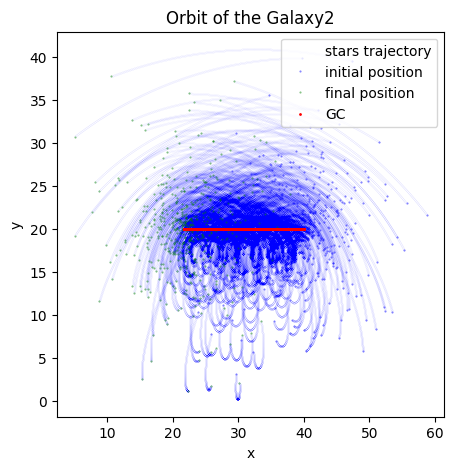

In [20]:
#let us make a plot
plt.figure(figsize=(5,5))
plt.scatter(Galaxy2_orbit[:,1:,0], Galaxy2_orbit[:,1:,1], s=0.05, color='b', label='stars trajectory', alpha=0.01)
plt.plot(Galaxy2_orbit[0,1:,0], Galaxy2_orbit[0,1:,1], 'o', markersize=0.5, c='b', label='initial position', alpha=0.5)
plt.plot(Galaxy2_orbit[-1,1:,0], Galaxy2_orbit[-1,1:,1], 'o', markersize=0.5, c='g', label='final position', alpha=0.5)
plt.scatter(Galaxy2_orbit[:,0,0], Galaxy2_orbit[:,0,1], s=1, color='r', label='GC', zorder=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit of the Galaxy2')
plt.legend(loc='upper right')
plt.show()

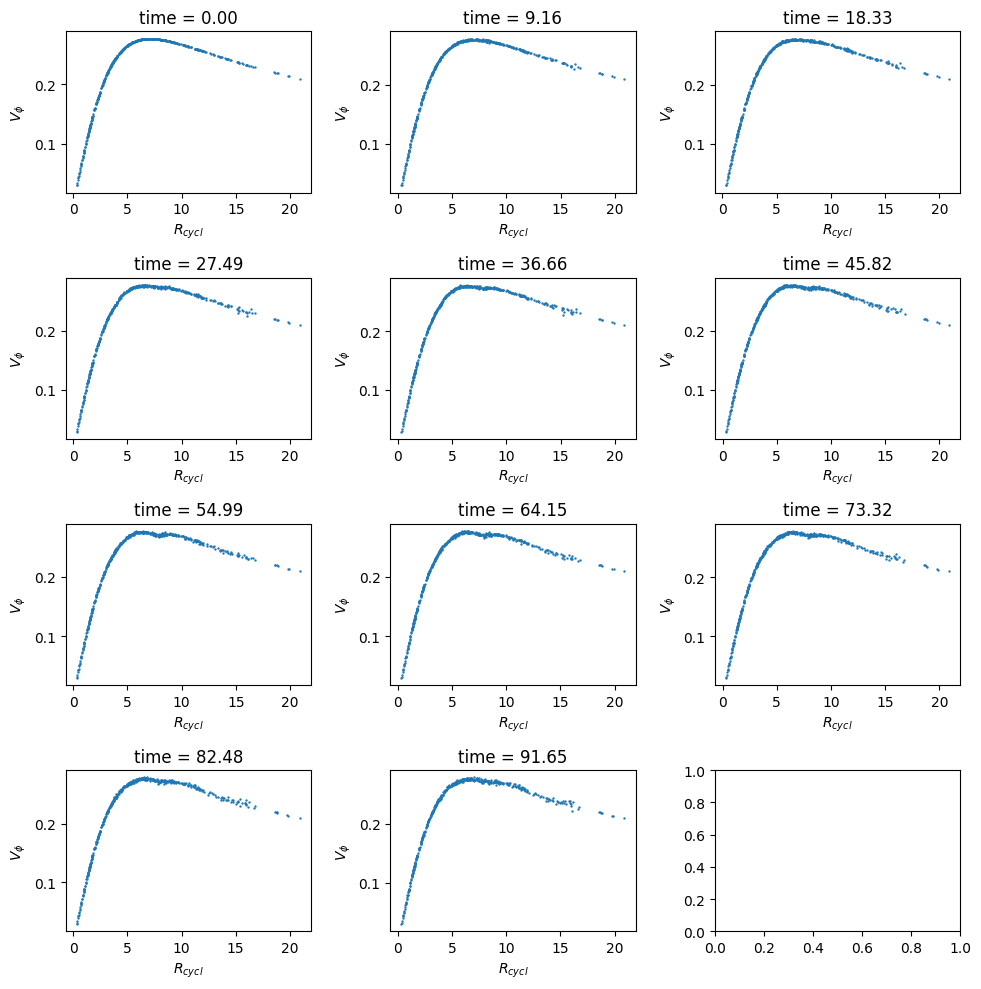

In [19]:
fig, axs = plt.subplots(4, 3, figsize=(10,10))

i_plot = 0
for i in range(0, len(Galaxy2_time), int(len(Galaxy2_time)/10)):
    ax = axs.flatten()[i_plot]
    time_prov = (i*h)/tsimulation
    ax.scatter(Galaxy2_Rcyl[i,:], Galaxy2_Vphi[i,:], s=0.5)

    ax.set_xlabel('$R_{cycl}$')
    ax.set_ylabel('$V_{\phi}$')
    ax.set_title(f'time = {Galaxy2_time[i]:.2f}')
    
    i_plot += 1

plt.tight_layout()
plt.show()

#### Cambiamo l'inclination

In [23]:
Galaxy1_inclined = Galaxy1.copy()

# inversion x-z coordinates:
pos_temp = Galaxy1_inclined.pos[:,0].copy()
Galaxy1_inclined.pos[:,2] = pos_temp
Galaxy1_inclined.pos[:,0] = pos_temp*0

print(Galaxy1.pos[:10])
print(Galaxy1_inclined.pos[:10])

[[  0.           0.           0.        ]
 [ -3.41958304  -1.90178796   0.        ]
 [-14.04683878  -2.40354145   0.        ]
 [ -4.61800261   6.26982091   0.        ]
 [ -6.04551619   0.25797427   0.        ]
 [ -1.39310426   1.5782338    0.        ]
 [ -1.15087665  -1.76243283   0.        ]
 [  0.59388673  -1.00378077   0.        ]
 [  2.42349151 -10.26649815   0.        ]
 [ -3.27932795   5.11803991   0.        ]]
[[  0.           0.           0.        ]
 [ -0.          -1.90178796  -3.41958304]
 [ -0.          -2.40354145 -14.04683878]
 [ -0.           6.26982091  -4.61800261]
 [ -0.           0.25797427  -6.04551619]
 [ -0.           1.5782338   -1.39310426]
 [ -0.          -1.76243283  -1.15087665]
 [  0.          -1.00378077   0.59388673]
 [  0.         -10.26649815   2.42349151]
 [ -0.           5.11803991  -3.27932795]]


In [26]:
posicion = np.concatenate((Galaxy1_inclined.pos, Galaxy2.pos))
velocidad = np.concatenate((Galaxy1_inclined.vel, Galaxy2.vel))
masas = np.concatenate((Galaxy1_inclined.mass, Galaxy2.mass))

Combined_inclined_Galaxies = Particles(posicion, velocidad, masas)

In [27]:
Combined_inclined_orbit, Combined_inclined_stars_vel, Combined_inclined_Etot, Combined_inclined_Ekin, Combined_inclined_Epot, Combined_inclined_time, Combined_inclined_Rcyl, Combined_inclined_Vphi, Combined_inclined_z = integration_leapfrog(galaxy=Combined_inclined_Galaxies, h=h, 
                                                                                                                                                                                                                                                tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)                               

/root/miniconda3/lib/python3.10/site-packages/fireworks-0.0.5-py3.10.egg/fireworks/particles.py:275: RuntimeWarning: divide by zero encountered in divide


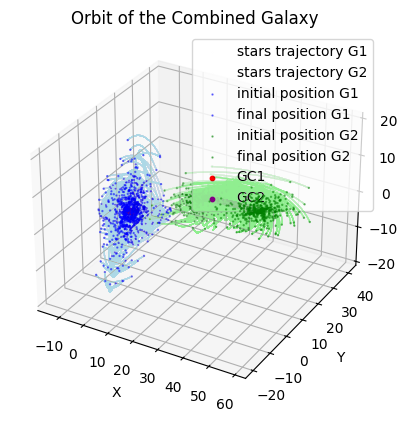

In [31]:
num = len(Galaxy1.mass) 

#let us make a 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Combined_inclined_orbit[:,1:num,0], Combined_inclined_orbit[:,1:num,1], Combined_inclined_orbit[:,1:num,2], s=0.05, color='lightblue', label='stars trajectory G1', alpha=0.01)
ax.scatter(Combined_inclined_orbit[:,num+1:,0], Combined_inclined_orbit[:,num+1:,1], Combined_inclined_orbit[:,num+1:,2], s=0.05, color='lightgreen', label='stars trajectory G2', alpha=0.01)
ax.scatter(Combined_inclined_orbit[0,1:num,0], Combined_inclined_orbit[0,1:num,1], Combined_inclined_orbit[0,1:num,2], s=0.5, color='b', label='initial position G1', alpha=0.5)
ax.scatter(Combined_inclined_orbit[-1,1:num,0], Combined_inclined_orbit[-1,1:num,1], Combined_inclined_orbit[-1,1:num,2], s=0.5, color='b', label='final position G1', alpha=0.5)
ax.scatter(Combined_inclined_orbit[0,num+1:,0], Combined_inclined_orbit[0,num+1:,1], Combined_inclined_orbit[0,num+1,2], s=0.5, color='g', label='initial position G2', alpha=0.5)
ax.scatter(Combined_inclined_orbit[-1,num+1:,0], Combined_inclined_orbit[-1,num+1:,1], Combined_inclined_orbit[-1,num+1:,2], s=0.5, color='g', label='final position G2', alpha=0.5)
ax.scatter(Combined_inclined_orbit[:,0,0], Combined_inclined_orbit[:,0,1], Combined_inclined_orbit[:,0,2], s=10, color='r', label='GC1', zorder=10)
ax.scatter(Combined_inclined_orbit[:,num,0], Combined_inclined_orbit[:,num,1], Combined_inclined_orbit[:,num,2], s=10, color='purple', label='GC2', zorder=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Orbit of the Combined Galaxy')
plt.legend(loc='upper right')
plt.show()
